In [23]:
import pandas as pd
import requests
import zipfile
import io
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [24]:
# URL of the ZIP file
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.zip"

# Download the ZIP file
response = requests.get(url)
zip_file = zipfile.ZipFile(io.BytesIO(response.content))

# Extract the desired file from the ZIP
with zip_file.open('bank-full.csv') as f:
    data = pd.read_csv(f, delimiter=';')
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


## Data Analysis

Lets try digging deeper into the data and try figuring out which features are more useful to us.
We'll use plots as a way to visualize the data and normalize columns/make informed decisions before we pass the data into our models.
We can get the following information from the data that we parsed above
Attribute Information:

Numeric Attributes:\
1 - age\
2 - duration: last contact duration, in seconds.\
3 - campaign: number of contacts performed during this campaign and for this client.\
4 - pdays: number of days that passed by after the client was last contacted from a previous campaign\
5 - previous: number of contacts performed before this campaign and for this client\
social and economic context attributes

Categorical Attributes:

1 - job : type of job ('admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')\
2 - marital : marital status ('divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)\
3 - education ('primary', 'secondary', 'tertiary','unknown')\
4 - default: has credit in default? ('no','yes','unknown')\
5 - housing: has housing loan? ('no','yes','unknown')\
6 - loan: has personal loan? ('no','yes','unknown')\

Other data related to the campaign:\
7 - contact: contact communication type ('cellular','telephone')\
8 - month: last contact month of year ('jan', 'feb', 'mar', ..., 'nov', 'dec')\
9 - day_of_week: last contact day of the week (1-7)\
10 - poutcome: outcome of the previous marketing campaign ('failure','unknown','success')\

In [25]:
clean_data = data.copy()
# We need to remove duplicate nodes
clean_data.drop_duplicates(subset=None, keep='first', inplace=True)
clean_data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [26]:
# clean columns of data
print(clean_data['poutcome'].value_counts())
# now let's replace all unknown jobs with blue-collar.
# It will not significantly impact the data as the highest number of jobs are already blue-collar.
clean_data.loc[clean_data['job'] == 'unknown','job'] = 'blue-collar'

print(clean_data['marital'].value_counts())

unknown    36959
failure     4901
other       1840
success     1511
Name: poutcome, dtype: int64
married     27214
single      12790
divorced     5207
Name: marital, dtype: int64


In [27]:
print(clean_data['education'].value_counts())
# we can move the unknown to primary as that would be the basic education category
clean_data.loc[clean_data['education'] == 'unknown', 'education'] = 'primary'

secondary    23202
tertiary     13301
primary       6851
unknown       1857
Name: education, dtype: int64


<Axes: xlabel='y', ylabel='count'>

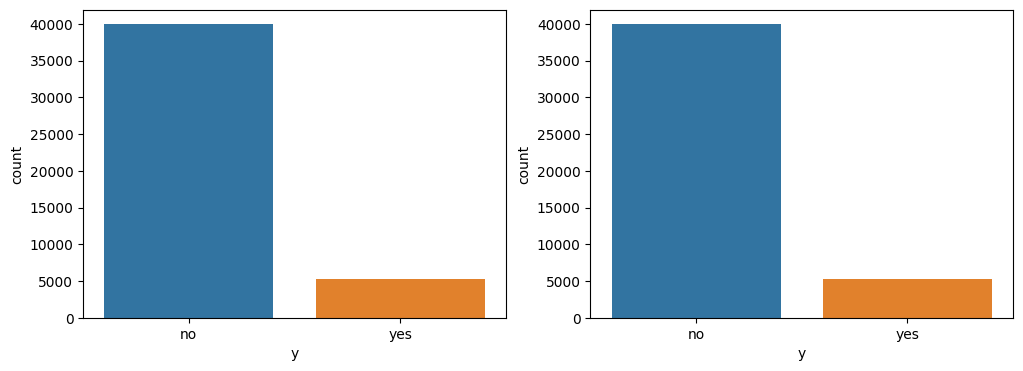

In [28]:
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

clean_data['poutcome'].value_counts()
plt.figure(figsize=(12,4))
plt.subplot(121)
data_has_poutcome =  clean_data.loc[clean_data['poutcome'] != 'nonexistent',['y']]
sns.countplot(x='y',data=clean_data)
plt.subplot(122)
data_doesnothave_poutcome =  clean_data.loc[clean_data['poutcome'] == 'nonexistent',['y']]
sns.countplot(x='y',data=clean_data)

<Axes: xlabel='housing', ylabel='count'>

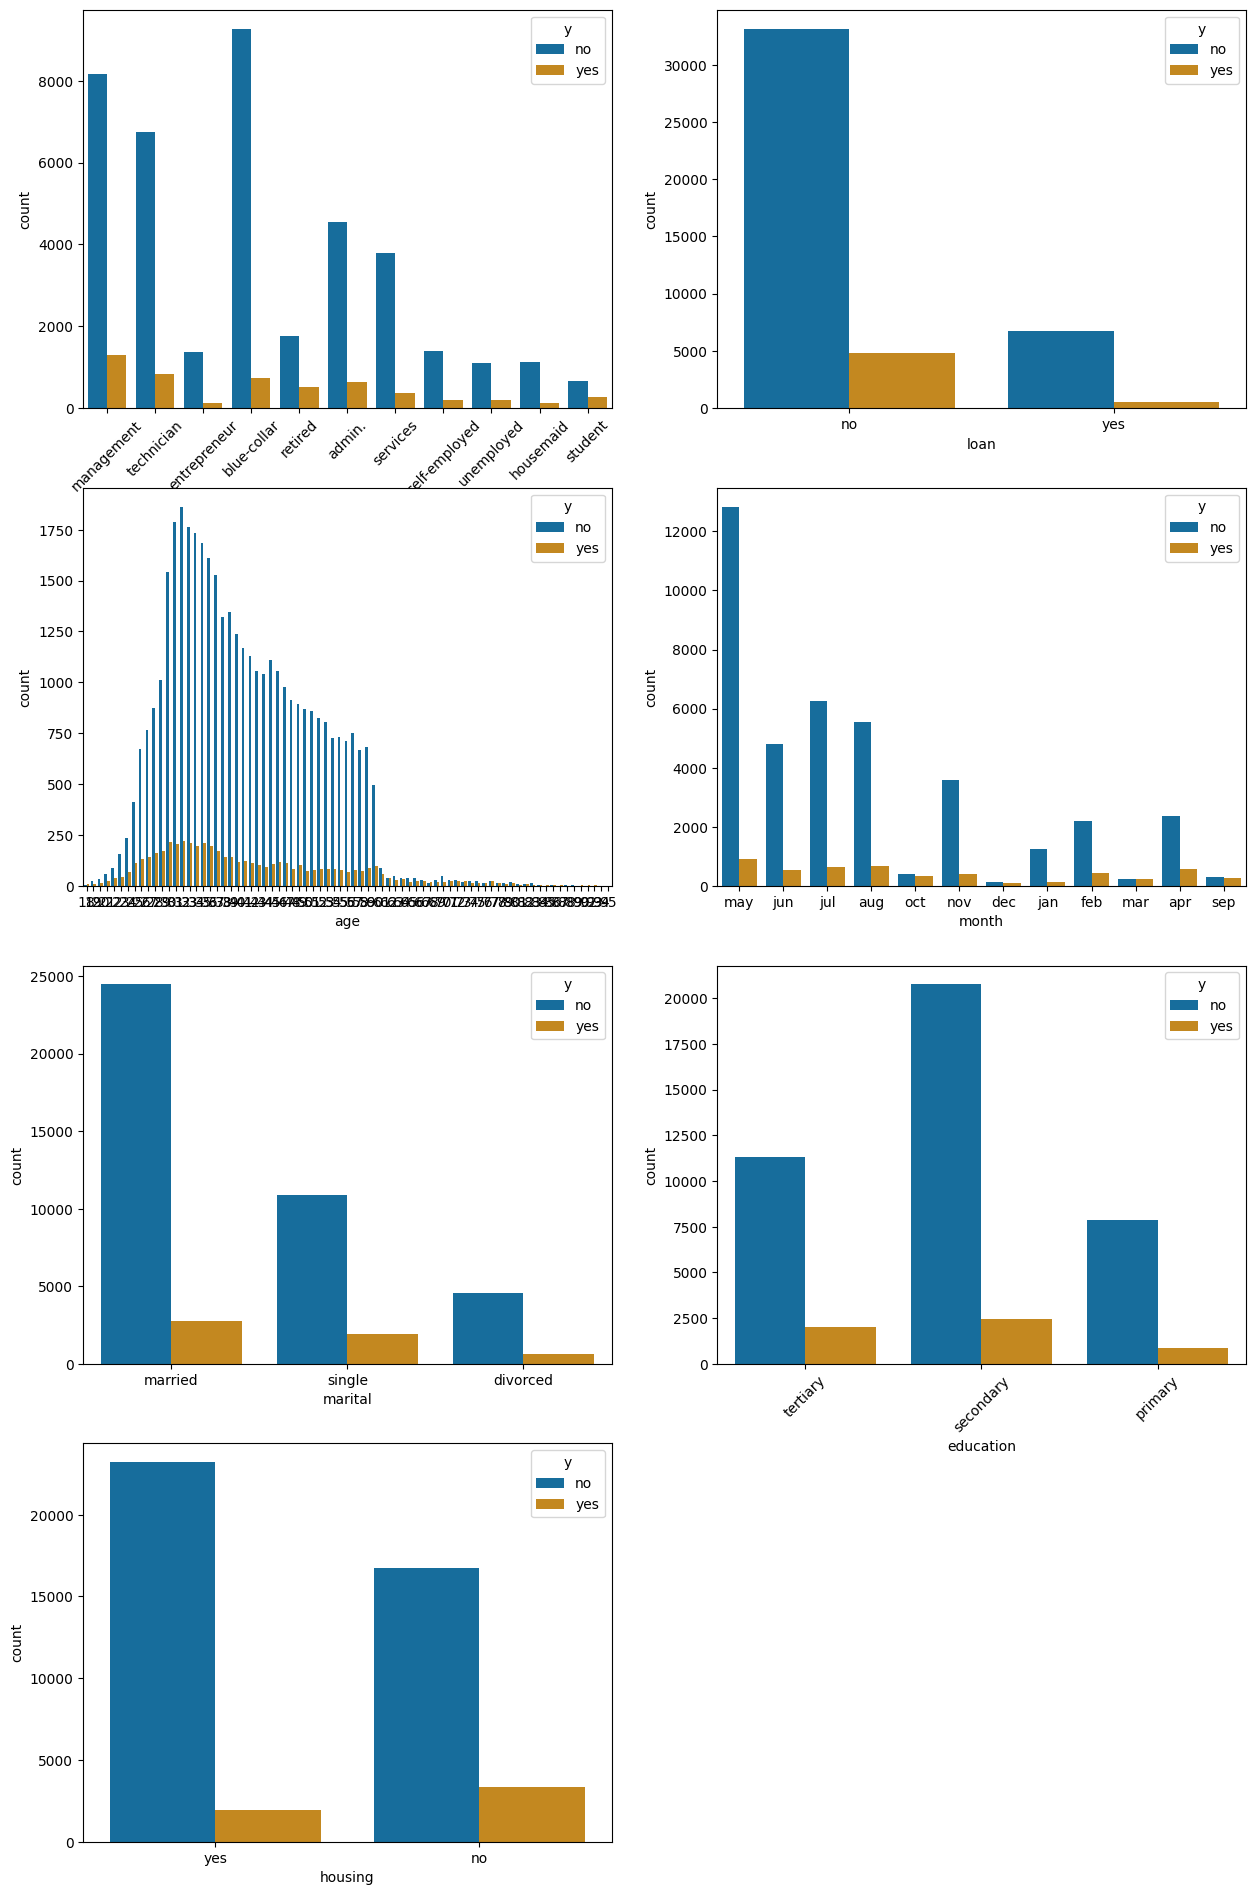

In [29]:
# Visualising the features and how they change
plt.figure(figsize = (15, 30))
sx = plt.subplot(5,2,1)
sns.countplot(x="job",hue="y", data=clean_data, palette="colorblind")
sx.set_xticklabels(sx.get_xticklabels(),rotation=45)
sx = plt.subplot(5,2,2)
sns.countplot(x="loan",hue="y", data=clean_data, palette="colorblind")
sx = plt.subplot(5,2,3)
sns.countplot(x="age",hue="y", data=clean_data, palette="colorblind")
sx = plt.subplot(5,2,4)
sns.countplot(x="month",hue="y", data=clean_data, palette="colorblind")
sx = plt.subplot(5,2,5)
sns.countplot(x="marital",hue="y", data=clean_data, palette="colorblind")
sx = plt.subplot(5,2,6)
sns.countplot(x="education",hue="y", data=clean_data, palette="colorblind")
sx.set_xticklabels(sx.get_xticklabels(),rotation=45)
sx = plt.subplot(5,2,7)
sns.countplot(x="housing",hue="y", data=clean_data, palette="colorblind")

In [30]:
# Duration and it's correlation to the the output
campaign_vs_duration = px.scatter(clean_data, x="campaign", y="duration",color='y',template='simple_white')
campaign_vs_duration.show()

In [31]:
# Preprocessing
# Convert categorical variables using Label Encoding
label_encoders = {}
for column in ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'y']:
    label_encoders[column] = LabelEncoder()
    data[column] = label_encoders[column].fit_transform(data[column])

In [32]:
# Feature selection - Adjust according to your analysis
features = ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome']
target = 'y'

In [33]:
# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(data[features], data[target], test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### BASELINE MODEL USING LOGISGTIC REGRESSION

In [35]:
# Train the Logistic Regression model
baseline_model = LogisticRegression()
baseline_model.fit(X_train, y_train)

# Predictions
baseline_y_pred = baseline_model.predict_proba(X_test)[:, 1]

# Calculate AUC-ROC
baseline_auc_roc = roc_auc_score(y_test, baseline_y_pred)
print(f"AUC-ROC Score: {baseline_auc_roc}")

AUC-ROC Score: 0.8699909124776154


### Reguarlized Greedy Forest

In [36]:
!pip install rgf_python

In [37]:
from rgf.sklearn import RGFClassifier
from sklearn.metrics import roc_auc_score

# Train the Regularized Greedy Forest model
rgf_model = RGFClassifier(max_leaf=1000, algorithm="RGF", test_interval=100)
rgf_model.fit(X_train, y_train)

# Predictions
rgf_y_pred = rgf_model.predict_proba(X_test)[:, 1]

# Calculate AUC-ROC
rgf_auc_roc = roc_auc_score(y_test, rgf_y_pred)
print(f"AUC-ROC Score for RGF: {rgf_auc_roc}")

AUC-ROC Score for RGF: 0.919756335907286


### Gradient Boosted Trees

In [38]:
!pip install xgboost

In [39]:
import xgboost as xgb
from sklearn.metrics import roc_auc_score

# Train the Gradient Boosted Trees model
xgb_model = xgb.XGBClassifier(objective='binary:logistic', n_estimators=100, learning_rate=0.05, max_depth=5)
xgb_model.fit(X_train, y_train)

# Predictions
xgb_y_pred = xgb_model.predict_proba(X_test)[:, 1]

# Calculate AUC-ROC
xgb_auc_roc = roc_auc_score(y_test, xgb_y_pred)
print(f"AUC-ROC Score for Gradient Boosted Trees: {xgb_auc_roc}")

AUC-ROC Score for Gradient Boosted Trees: 0.92200689240853


### One-Class SVM

In [40]:
import numpy as np
from sklearn.svm import OneClassSVM
from sklearn.metrics import roc_auc_score

# Assuming class '0' is the "normal" class for this example
normal_class = 0

# Preparing the data: Use only the "normal" class for training
X_train_normal = X_train[y_train == normal_class]

# Train the One-Class SVM model using the rbf kernel
ocsvm_model = OneClassSVM(kernel='rbf', gamma='auto').fit(X_train_normal)

# Predictions: -1 for outliers and 1 for inliers. Convert to match your class labels.
ocsvm_y_pred = ocsvm_model.predict(X_test)
ocsvm_y_pred = np.where(ocsvm_y_pred == 1, normal_class, 1 - normal_class)  # Convert to binary classification scheme

# Calculate AUC-ROC (Note: Interpretation of AUC-ROC is different here due to the nature of one-class classification)
ocsvm_auc_roc = roc_auc_score(y_test, ocsvm_y_pred)
print(f"AUC-ROC Score for One-Class SVM: {ocsvm_auc_roc}")

AUC-ROC Score for One-Class SVM: 0.6265383893646019


#### Isolation Forest

In [41]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_auc_score
import numpy as np

# Train the Isolation Forest model
# Note: The contamination parameter is important - it represents the expected proportion of outliers in the data set
iso_forest_model = IsolationForest(n_estimators=1000, contamination='auto', random_state=43)
iso_forest_model.fit(X_train)

# Predictions: -1 for outliers and 1 for inliers. Convert to match your class labels.
# Here, I'm assuming that the positive class (e.g., '1') is the outlier/anomaly class.
iso_forest_y_pred = iso_forest_model.predict(X_test)
iso_forest_y_pred = np.where(iso_forest_y_pred == 1, 0, 1)  # Convert to binary classification scheme

# Calculate AUC-ROC
iso_forest_auc_roc = roc_auc_score(y_test, iso_forest_y_pred)
print(f"AUC-ROC Score for Isolation Forest: {iso_forest_auc_roc}")

AUC-ROC Score for Isolation Forest: 0.5760317519230876


#### SVM Model

In [42]:
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score

In [43]:
# Train the Linear SVM model
linear_svm_model = SVC(kernel='linear', probability=True)
linear_svm_model.fit(X_train, y_train)

# Predictions
linear_svm_y_pred = linear_svm_model.predict_proba(X_test)[:, 1]

# Calculate AUC-ROC
linear_svm_auc_roc = roc_auc_score(y_test, linear_svm_y_pred)
print(f"AUC-ROC Score for Linear SVM: {linear_svm_auc_roc}")

AUC-ROC Score for Linear SVM: 0.864581565930874


In [44]:
# Train the Quadratic SVM model
quadratic_svm_model = SVC(kernel='poly', degree=2, probability=True)
quadratic_svm_model.fit(X_train, y_train)

# Predictions
quadratic_svm_y_pred = quadratic_svm_model.predict_proba(X_test)[:, 1]

# Calculate AUC-ROC
quadratic_svm_auc_roc = roc_auc_score(y_test, quadratic_svm_y_pred)
print(f"AUC-ROC Score for Quadratic SVM: {quadratic_svm_auc_roc}")


AUC-ROC Score for Quadratic SVM: 0.7916180630990342


In [45]:
# Train the Cubic SVM model
cubic_svm_model = SVC(kernel='poly', degree=3, probability=True)
cubic_svm_model.fit(X_train, y_train)

# Predictions
cubic_svm_y_pred = cubic_svm_model.predict_proba(X_test)[:, 1]

# Calculate AUC-ROC
cubic_svm_auc_roc = roc_auc_score(y_test, cubic_svm_y_pred)
print(f"AUC-ROC Score for Cubic SVM: {cubic_svm_auc_roc}")


AUC-ROC Score for Cubic SVM: 0.8639103180033455
